# Notebook 2: Differential Expression Analysis
In this notebook, we will compare patients with MCI progressive (MCI_Decline_AD) vs MCI stable (MCI_Stable_AD) to identify which proteins that are differentially expressed/abundant, using the Limma lmfit algorithm. 

### As-Is Software Disclaimer

This notebook is delivered "As-Is". Notwithstanding anything to the contrary, DNAnexus will have no warranty, support, liability or other obligations with respect to Materials provided hereunder.

[MIT License](https://github.com/dnanexus/UKB_RAP/blob/main/LICENSE) applies to this notebook.

### JupyterLab app details

<b>Launch configuration:</b> 
- App name: JupyterLab
- Kernel: R
- Instance type: mem1_ssd1_v2_x2
- Runtime: =~ 5 min
- Cost: =~ £0.015


<b>Data description:</b> The inputs for this notebook are
1. A matrix of samples and their respective protein expression (NPX). This file has the expression values for 400 protein for 59 samples (29 MCI stable, 30 MCI progressive). This data can be found in `npx.csv`, created by the previous notebook.
2. A summary file giving the sample IDs labeled with MCI stable or MCI progressive. This data can be found in `pheno.csv`, created by the previous notebook.

**Note:** R kernel takes 1 min to setup when you open this notebook (a little slower than python kernel)

### Dependencies

|Library |License|
|:------------- |:-------------|
|[Tidyverse](https://www.tidyverse.org/packages/) | [MIT](https://cran.r-project.org/web/licenses/MIT)|
|[Limma](https://bioconductor.org/packages/release/bioc/html/limma.html) |[GPL](https://cran.r-project.org/web/licenses/GPL-3)|

**Install Packages**

Uncomment the install commands if you are comfortable with the library license and want to install and run the parts notebook that depend on the library.

_Note: Package installation takes ~3 minutes_

In [3]:
# Libraries to install if running locally and on RAP
# install.packages("tidyverse")
# install.packages('BiocManager')
# BiocManager::install("limma")

# Additional libraries to install if running locally, these are already installed on RAP
# install.packages("readr")
# install.packages("magrittr")
# install.packages("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.20), R 4.2.0 (2022-04-22)

Installing package(s) 'limma'

Old packages: 'BiasedUrn', 'bslib', 'cachem', 'coloc', 'colorspace',
  'commonmark', 'covr', 'curl', 'data.table', 'DEoptimR', 'digest', 'DT',
  'epiR', 'evaluate', 'fansi', 'fastmap', 'fontawesome', 'fs', 'gh', 'glmnet',
  'gmp', 'gtable', 'highr', 'htmltools', 'htmlwidgets', 'httpuv', 'httr2',
  'incidence', 'IRkernel', 'isoband', 'knitr', 'later',
  'MendelianRandomization', 'openssl', 'pbdZMQ', 'pkgdown', 'prevalence',
  'processx', 'profvis', 'ps', 'quantreg', 'Rcpp', 'RcppArmadillo', 'repr',
  'rjags', 'rmarkdown', 'Rmpfr', 'robustbase', 'roxygen2', 'sass', 'shiny',
  'sourcetools', 'spelling', 'stringi', 'susieR', 'testthat', 'timechange',
  'tinytex', 'utf8', 'viridis', 'viridisLite', 

**Declare input and output file names**

In notebook 1, we generate the following files and saved it in our platform
1. A matrix of samples and their respective protein expression (NPX). This file has the expression values for 400 protein for 59 samples (29 MCI stable, 30 MCI progressive). This data can be found in `npx.csv`, created by the previous notebook.
2. A summary file giving the sample IDs labeled with MCI stable or MCI progressive. This data can be found in `pheno.csv`, created by the previous notebook.

In [1]:
# Input files
npx_file <- "npx.csv"
pheno_file <- "pheno.csv"

# Output file
deseq_results_file <- "de_results.csv"
output_dir <- "/output/"

**Download Data**

 We download these files using CLI dx-toolbox command, `dx download <file_name>`. Replace the "<file path for npx.csv>" and <"file path for pheno.csv>" with the location of these files on your project

In [7]:
npx_download_file <- "<file path for npx.csv>"
pheno_download_file <- "<file path for pheno.csv>"

system(paste("dx download", npx_download_file))
system(paste("dx download", pheno_download_file))

_Note: At this point, we suggest creating a snapshot of the environment for resuse --> DNAnexus/Create SnapshotOnce a snapshot is created, the object may be used when launching a new JupyterLab instance and will contain all installed packages and any downloaded data._

## 2. Load Libraries

In [3]:
library(limma)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
# Additional libraries to load
library(readr)
library(magrittr)
library(dplyr)


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




## 3. Load Data

In [8]:
# Read the expression dataframe
npx_df <- read_csv(npx_file, show_col_types = FALSE)

# Read the phenotype datafram
pheno_df <- read_csv(pheno_file, show_col_types = FALSE)

In [9]:
# Set row names to be the sample ids so that we can use the sample ids to ensure the order of samples in
# the expression data frame and phenotype dataframe are consistent when input into Limma
npx_df <- column_to_rownames(npx_df, var = "Plasma_Sample")

In [10]:
colnames(npx_df)[1:5]
dim(npx_df)
head(npx_df)

[1] "CA1"   "ICAM1" "CHL1"  "TGFBI" "ENG"

[1]  59 400

,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,SERPINA7,IGFBP3,CR2,SERPINA5,⋯,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H0529.3,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,5.28013,5.53985,5.83288,7.62461,⋯,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
H0441.1,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,5.36719,5.22006,6.54894,7.85164,⋯,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
H0558.3,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,5.56897,5.28240,7.06695,7.56996,⋯,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
H0499.2,7.59577,6.80282,4.51559,9.17979,3.19292,2.71104,5.54439,5.72146,6.77939,8.34760,⋯,3.02522,6.03356,5.17391,3.27962,6.21488,8.65480,6.96169,6.80551,3.16607,6.46900
H0468.3,7.25945,6.91728,4.84307,9.91809,3.47692,3.01978,5.65406,5.54186,6.06626,8.20922,⋯,2.26329,5.23342,4.91143,2.10269,2.55051,7.94390,5.32065,6.48469,3.22015,5.99774
H0348.1,7.26665,7.54874,4.73500,10.14874,3.45586,2.65961,5.73624,5.65758,6.76388,8.87777,⋯,2.84494,6.04939,5.36281,2.90052,2.66707,8.81831,6.62835,6.37172,3.63646,6.68152


In [11]:
colnames(pheno_df)
dim(pheno_df)
head(pheno_df)

[1] "Plasma_Sample"   "PIDN"            "Age_at_Baseline" "Sex"            
[5] "Outcome"

[1] 59  5

Plasma_Sample,PIDN,Age_at_Baseline,Sex,Outcome
<chr>,<dbl>,<chr>,<chr>,<chr>
H0529.3,9677,90+,Male,MCI_Decline_AD
H0441.1,9974,90+,Female,MCI_Stable_AD
H0558.3,9681,90+,Female,MCI_Decline_AD
H0499.2,9502,88,Male,MCI_Stable_AD
H0468.3,9635,87,Female,MCI_Stable_AD
H0348.1,9571,86,Male,MCI_Decline_AD


## 4. Format data

These formating steps are specific to this test case

For our phenotype data we will replace "90+" with "90" so this can be a continuous variable for our downstream differential expression analysis

For expression data, we will format protein names to be consistent to allow us to compare publication findings and what R generated since "-" were replaced with "" or ".". Additionally some of the protein names are mapped to gene symbols

Note: Couldn't find mapping for TNF-alpha

In [12]:
# Make age continuous values
pheno_df[pheno_df[,"Age_at_Baseline"] == "90+", "Age_at_Baseline"] <- "90"

In [13]:
head(pheno_df)

Plasma_Sample,PIDN,Age_at_Baseline,Sex,Outcome
<chr>,<dbl>,<chr>,<chr>,<chr>
H0529.3,9677,90,Male,MCI_Decline_AD
H0441.1,9974,90,Female,MCI_Stable_AD
H0558.3,9681,90,Female,MCI_Decline_AD
H0499.2,9502,88,Male,MCI_Stable_AD
H0468.3,9635,87,Female,MCI_Stable_AD
H0348.1,9571,86,Male,MCI_Decline_AD


In [14]:
lookup <- c(
    "NF-L" = "NEFL",
    "IL-8" = "IL8",
    "VEGF-A" = "VEGFA",
    "MMP-3" = "MMP.3",
    "TIMP-4" = "TIMP4",
    "CSF-1" = "CSF.1",
    "HO-1" = "HO.1",
    "MCP-1" = "MCP.1",
    "FGF-21" = "FGF.21",
    "HL-1" = "ASGR1",
    "TNF-R1" = "TNF.R1",
    "TGF-alpha" = "TGF.alpha",
    "IGFBP-2" = "IGFBP.2",
    "MMP-7" = "MMP7",
    "SIRL-1" = "VSTM1",
    "PD-L1" = "PD.L1",
    "GDF-15" = "GDF.15",
    "IL-17A" = "IL.17A",
    "Gal-1" = "Gal.1",
    "FKBP-7" = "FKBP7")

In [15]:
npx_df <- rename(npx_df, all_of(lookup))

## 5. Run Limma

In [16]:
# Sort counts by sample order in phenotype
sample_id <- pheno_df %>% pull(Plasma_Sample)
npx_df <- npx_df[sample_id, ]

In [17]:
sample_id

[1] "H0529.3" "H0441.1" "H0558.3" "H0499.2" "H0468.3" "H0348.1" "H0381.2"
 [8] "H0008.3" "H0132.1" "H0190.2" "H0423.1" "H0819.1" "H0102.1" "H0278.1"
[15] "H0335.1" "H0366.1" "H0140.1" "H0202.1" "H0461.3" "H0760.1" "H0168.2"
[22] "H0118.1" "H0167.1" "H0708.3" "H0602.2" "H0722.1" "H0061.1" "H0377.3"
[29] "H0401.1" "H0425.1" "H0469.1" "H0850.3" "H0126.1" "H0548.1" "H0221.1"
[36] "H0233.3" "H0347.1" "H0804.1" "H0613.1" "H0002.1" "H0407.1" "H0626.1"
[43] "H0775.1" "H0798.1" "H0059.1" "H0143.1" "H0559.1" "H0145.1" "H2031.1"
[50] "H0866.1" "H0442.2" "H0868.1" "H2012.1" "H0522.1" "H0730.1" "H0860.1"
[57] "H0978.1" "H0225.1" "H0981.2"

In [18]:
head(npx_df)

,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,SERPINA7,IGFBP3,CR2,SERPINA5,⋯,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H0529.3,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,5.28013,5.53985,5.83288,7.62461,⋯,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
H0441.1,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,5.36719,5.22006,6.54894,7.85164,⋯,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
H0558.3,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,5.56897,5.28240,7.06695,7.56996,⋯,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
H0499.2,7.59577,6.80282,4.51559,9.17979,3.19292,2.71104,5.54439,5.72146,6.77939,8.34760,⋯,3.02522,6.03356,5.17391,3.27962,6.21488,8.65480,6.96169,6.80551,3.16607,6.46900
H0468.3,7.25945,6.91728,4.84307,9.91809,3.47692,3.01978,5.65406,5.54186,6.06626,8.20922,⋯,2.26329,5.23342,4.91143,2.10269,2.55051,7.94390,5.32065,6.48469,3.22015,5.99774
H0348.1,7.26665,7.54874,4.73500,10.14874,3.45586,2.65961,5.73624,5.65758,6.76388,8.87777,⋯,2.84494,6.04939,5.36281,2.90052,2.66707,8.81831,6.62835,6.37172,3.63646,6.68152


In [19]:
# Specify the sample condition (MCI_Stable_AD vs. MCI_Decline_AD)
# Note: the publication also mentioned including CDR-SBM measurements as an additional covariate
# but this data isn't found in the supplementary data provided
outcome <- factor(pheno_df$Outcome)
age <- as.numeric(pheno_df$Age_at_Baseline)
sex <- factor(pheno_df$Sex)

In [20]:
design <- model.matrix(~0 + outcome + age + sex, pheno_df)

In [21]:
head(design)

,outcomeMCI_Decline_AD,outcomeMCI_Stable_AD,age,sexMale
1,1,0,90,1
2,0,1,90,0
3,1,0,90,0
4,0,1,88,1
5,0,1,87,0
6,1,0,86,1


In [22]:
# lmFit expects input array to have structure: protein x sample
# lmFit fits a linear model using weighted least squares for each protein:
fit <- lmFit(t(npx_df), design)

In [23]:
# Comparisons between groups (log fold-changes) are obtained as contrasts of
# these fitted linear models:
# Samples are grouped based on experimental condition
# The variability of protein expression is compared between these groups
contr <- makeContrasts(outcomeMCI_Decline_AD - outcomeMCI_Stable_AD, levels = design)

In [24]:
contr

,outcomeMCI_Decline_AD - outcomeMCI_Stable_AD
outcomeMCI_Decline_AD,1
outcomeMCI_Stable_AD,-1
age,0
sexMale,0


In [25]:
# Estimate contrast for each protein
tmp <- contrasts.fit(fit, contr)

In [26]:
# Empirical Bayes smoothing of standard errors (shrinks standard errors
# that are much larger or smaller than those from other proteins towards the average standard error)
tmp <- eBayes(tmp)

In [27]:
tmp

An object of class "MArrayLM"
$coefficients
       Contrasts
        outcomeMCI_Decline_AD - outcomeMCI_Stable_AD
  CA1                                    -0.05543695
  ICAM1                                  -0.05037365
  CHL1                                   -0.13747566
  TGFBI                                  -0.04227922
  ENG                                    -0.04661332
395 more rows ...

$rank
[1] 4

$assign
[1] 1 1 2 3

$qr
$qr
  outcomeMCI_Decline_AD outcomeMCI_Stable_AD          age     sexMale
1            -5.4772256            0.0000000 -414.4434018 -2.73861279
2             0.0000000           -5.3851648 -422.6425897 -2.78543007
3             0.1825742            0.0000000  -57.9129350 -0.09943583
4             0.0000000            0.1856953    0.1331912 -3.83816256
5             0.0000000            0.1856953    0.1159239 -0.10172476
54 more rows ...

$qraux
[1] 1.182574 1.185695 1.209287 1.160594

$pivot
[1] 1 2 3 4

$tol
[1] 1e-07

$rank
[1] 4


$df.residual
[1] 55 55 5

In [28]:
# Extract results
top.table <- topTable(tmp, sort.by = "P", n = Inf)
results <-  as.data.frame(top.table)

## 6. Plot results

#### Convert results to a data.frame

In [29]:
results_df <- data.frame(results) %>%
    rownames_to_column(var = "protein")

# Add FC column since this is what the paper uses for filtering proteins
results_df$FC<-2^(abs(results_df$logFC))

In [30]:
head(results_df, 3)
dim(results_df)

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,FC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NF-L,0.4534274,5.155294,3.364732,0.001352144,0.3156027,-1.341150,1.369289
2,IL8.1,0.5106782,5.481614,3.313615,0.001578013,0.3156027,-1.449758,1.424720
3,TIMP-4,0.3281241,4.355466,3.077642,0.003163809,0.3590204,-1.937656,1.255380


[1] 400   8

#### Create plot 

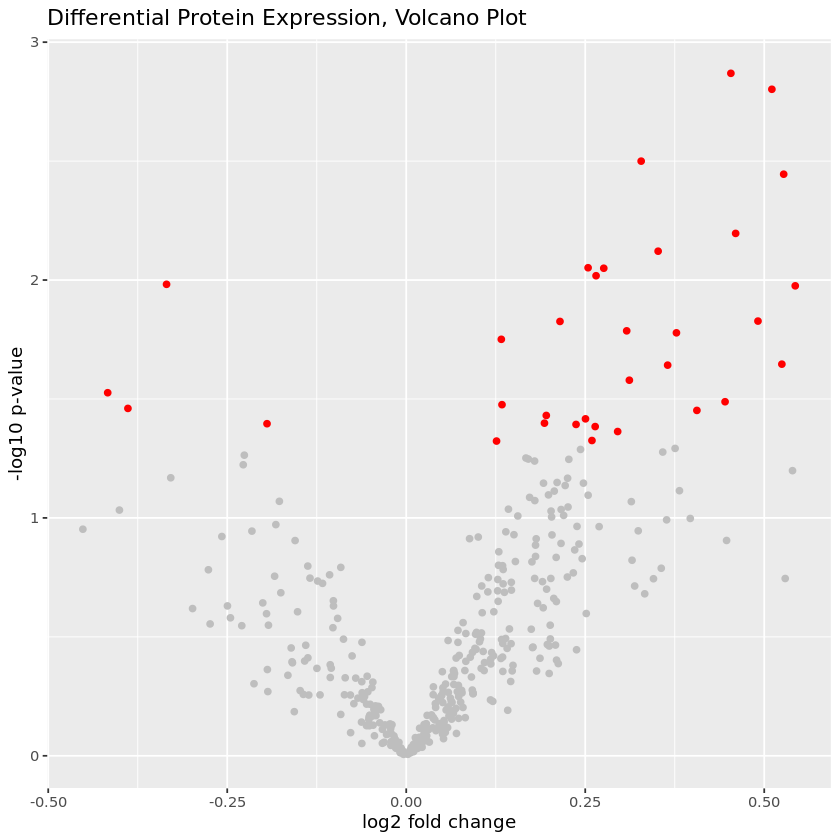

In [31]:
volcano_plot <- ggplot(results_df) +
    geom_point(aes(x = logFC, y = -log10(P.Value), color = ifelse(P.Value<0.05, 'red', 'grey'))) +
    scale_color_identity() +
    labs(x = "log2 fold change", y = "-log10 p-value") +
    ggtitle("Differential Protein Expression, Volcano Plot")

volcano_plot

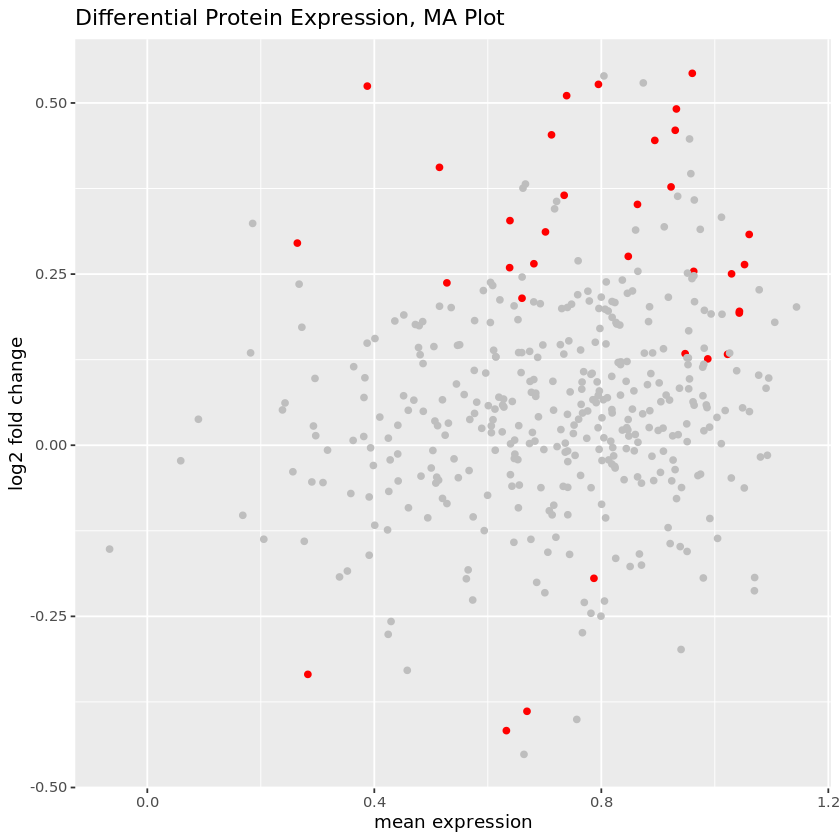

In [32]:
# Plot MA plot
ma_plot <- ggplot(results_df) +
    geom_point(aes(x = log10(AveExpr), y = logFC, color = ifelse(P.Value<0.05, 'red', 'grey'))) +
    scale_color_identity() +
    labs(x = "mean expression", y = "log2 fold change") +
    ggtitle("Differential Protein Expression, MA Plot")

ma_plot

## 7. Compare significant DE proteins

In [36]:
pub_de_protein_file <- "Nominally_Significant_Proteins-Table_1.csv"
pub_de_protein_download_file <- "file path for Nominally_Significant_Proteins-Table_1.csv"

In [37]:
# Download using dx-toolkit
system(paste("dx download", pub_de_protein_download_file))

In [38]:
# Read the counts dataframe
pub_de_protein_df <- read_csv(pub_de_protein_file, show_col_types = FALSE)

New names:
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`


In [39]:
# sort by p-value 
dim(pub_de_protein_df)
head(pub_de_protein_df, decreasing=FALSE, n=20)

[1] 44 17

Protein,Panel,UniProt ID,Description,logFC,FC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,...14,...15,...16,...17
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<lgl>
NF-L,Olink NEURO EXPLORATORY(v.3901),P07196,Neurofilamentlightpolypeptide,0.5929488,1.5083265,0.29436372,0.8915339,5.155294,3.979653,0.0002036750,0.0814700,0.5077088,NA,NA,NA,NA
IL-8,Olink INFLAMMATION(v.3021),P10145,Interleukin-8 (IL-8),0.5964094,1.5119489,0.26343010,0.9293886,5.481614,3.589412,0.0007057214,0.1411443,-0.5214116,NA,NA,adj.P.Val < 0.20,NA
VEGF-A,Olink IMMUNO-ONCOLOGY(v.3101),P15692,Vascular endothelial growth factor A (VEGF-A),0.3374201,1.2634951,0.13795228,0.5368879,9.179483,3.389957,0.0012987893,0.1472101,-1.0241882,NA,NA,adj.P.Val < 0.25,NA
TNFRSF12A,Olink IMMUNO-ONCOLOGY(v.3101),Q9NP84,Tumor necrosis factor receptor superfamily member 12A,0.4490206,1.3651132,0.17381921,0.7242220,7.306673,3.269729,0.0018591664,0.1472101,-1.3187988,NA,NA,FC > 50%,NA
CX3CL1,Olink IMMUNO-ONCOLOGY(v.3101),P78423,Fractalkine (CX3CL1 ),0.3515657,1.2759446,0.12949477,0.5736367,7.038993,3.172567,0.0024714966,0.1472101,-1.5519533,NA,NA,NA,NA
LTBR,Olink CARDIOVASCULAR III(v.6112),P36941,Lymphotoxin-beta receptor (LTBR),0.3463565,1.2713458,0.12658584,0.5661271,4.799556,3.158274,0.0025761761,0.1472101,-1.5858699,NA,NA,NA,NA
PHOSPHO1,Olink NEURO EXPLORATORY(v.3901),Q8TCT1,Phosphoethanolamine/phosphocholinephosphatase,0.2942856,1.2262776,0.10392559,0.4846457,4.573599,3.098057,0.0030645817,0.1532291,-1.7276460,NA,NA,NA,NA
MMP-3,Olink CARDIOVASCULAR III(v.6112),P08254,Matrix metalloproteinase-3 (MMP-3),0.5253266,1.4392594,0.16857896,0.8820743,8.516487,2.950967,0.0046458343,0.1845394,-2.0662171,NA,NA,NA,NA
CD302,Olink NEURO EXPLORATORY(v.3901),Q8IX05,CD302 antigen,0.3570392,1.2807947,0.11439008,0.5996883,4.925693,2.948718,0.0046750619,0.1845394,-2.0713062,NA,NA,NA,NA


In [40]:
# Get significant protein found in publication
pub_de_protein_id <- pub_de_protein_df %>% pull(Protein)

In [41]:
# Get significant proteins from our analysis
# This paper notes that their significance was based on p-value not adjusted p-value
threshold <- 0.05
de_protein_df <- results_df[results_df[,'P.Value']<threshold & abs(results_df[,'FC'])>0.1,]

dim(de_protein_df)
head(de_protein_df, n=20)

[1] 33  8

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,FC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NF-L,0.4534274,5.155294,3.364732,0.001352144,0.3156027,-1.341150,1.369289
2,IL8.1,0.5106782,5.481614,3.313615,0.001578013,0.3156027,-1.449758,1.424720
3,TIMP-4,0.3281241,4.355466,3.077642,0.003163809,0.3590204,-1.937656,1.255380
4,IL-8,0.5271722,6.236465,3.033637,0.003590204,0.3590204,-2.026072,1.441102
5,MMP-3,0.4600895,8.516487,2.829248,0.006367758,0.3846158,-2.425405,1.375627
6,TNFRSF12A,0.3518226,7.306673,2.766111,0.007564079,0.3846158,-2.544839,1.276172
7,VEGF-A,0.2539972,9.179483,2.706533,0.008879147,0.3846158,-2.655771,1.192507
8,CX3CL1,0.2758900,7.038993,2.704770,0.008921077,0.3846158,-2.659027,1.210741
9,LTBR,0.2651338,4.799556,2.677539,0.009592166,0.3846158,-2.709124,1.201748


In [42]:
de_protein_id <- de_protein_df %>% pull(protein)

In [43]:
pub_de_protein_id

[1] "NF-L"      "IL-8"      "VEGF-A"    "TNFRSF12A" "CX3CL1"    "LTBR"     
 [7] "PHOSPHO1"  "MMP-3"     "CD302"     "CCL23"     "TIMP-4"    "PTN"      
[13] "CSF-1"     "CXCL9"     "ST1A1"     "HO-1"      "ST2"       "MCP-1"    
[19] "MB"        "PIGF"      "TNFRSF4"   "EPHB4"     "FGF-21"    "HL-1"     
[25] "TNF-R1"    "TFF3"      "SNCG"      "TGF-alpha" "DCN"       "CD27"     
[31] "NOS3"      "NCR1"      "IGFBP-2"   "MMP-7"     "CETN2"     "SIRL-1"   
[37] "PD-L1"     "GDF-15"    "FASLG"     "TNF-alpha" "IL-17A"    "PRTFDC1"  
[43] "Gal-1"     "FKBP-7"

In [44]:
de_protein_id

[1] "NF-L"      "IL8.1"     "TIMP-4"    "IL-8"      "MMP-3"     "TNFRSF12A"
 [7] "VEGF-A"    "CX3CL1"    "LTBR"      "NOS3"      "CXCL9"     "CXCL9.1"  
[13] "PHOSPHO1"  "CCL23"     "MB"        "CSF.1.1"   "IL-17A"    "ST2"      
[19] "TNFRSF4"   "KLB"       "MCP.2"     "CSF-1"     "ST1A1"     "FCGR2A"   
[25] "VEGFA.1"   "CCL23.1"   "OPG.1"     "CD6"       "GDNF"      "MCP.1.1"  
[31] "SIRL-1"    "NCR1"      "DNER"

In [45]:
# Compare
shared_protein_ids <- intersect(de_protein_id, pub_de_protein_id)

length(shared_protein_ids)
shared_protein_ids

[1] 20

[1] "NF-L"      "TIMP-4"    "IL-8"      "MMP-3"     "TNFRSF12A" "VEGF-A"   
 [7] "CX3CL1"    "LTBR"      "NOS3"      "CXCL9"     "PHOSPHO1"  "CCL23"    
[13] "MB"        "IL-17A"    "ST2"       "TNFRSF4"   "CSF-1"     "ST1A1"    
[19] "SIRL-1"    "NCR1"

Publication found 44 DE proteins, reported in Supplementary Table 2. 

According to the paper:

*A total of 44 proteins were significantly altered in MCI-progressors versus MCI-stable (P < 0.05), controlling for age, sex and baseline CDR-SOB (Fig. 1B, Supplementary Table 2). None of these were significant after multiple comparison corrections. These 44 differentially expressed proteins were all increased in MCI-progressors versus MCI-stable, except for PRTFDC1, ST1A1, CETN2 and NOS3, which were decreased. The proteins were primarily representative of inflammatory/chemotaxis (CCL23, CSF-1, CX3CL1, CXCL9, IL-8, LTBR, MCP-1, ST2, TNFRSF12A), extracellular matrix (MMP-3, PTN and TIMP-4), neurodegeneration (NF-L) and vascular processes (PGF, MB and VEGFA).* 

Our re-analysis of the data identified 33 proteins as differentially expressed with 20/33 being consistent with the publication. The exact overlap is likely due to some ambiguous information in the methods making it difficult to determine how covariates were used and what normalization was performed.

## 8. Export tabular results for all proteins to the platform

In [46]:
write.csv(de_protein_df, file = "de_results.csv")
system(paste("dx upload", deseq_results_file, "--destination", output_dir))